In [34]:
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt

In [35]:
def load_jets(root_dir, filename):
    """Load truth binary trees"""
    #root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [36]:
gt_trees = load_jets("data", "ginkgo_5000_jets_no_cuts_lambda_21_pt_min_36_jetp_400")  # My test file

## Load leaf-based grid results

In [87]:
train_leaves_ix = [len(x["leaves"])-1 for x in gt_trees[:5000]]  # only use the first 5000 leaves

In [90]:
#fig, ax = plt.subplots(nrows=1, ncols=1)
#fig.set_size_inches(8,8)

n_cuts = 40
n_lambda = 40

cut_vals = np.linspace(26, 43, n_cuts)
lambda_vals = np.linspace(1.35, 2.4, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

max_LL = -np.inf
mle_params = None

likelihood_surface = np.zeros((n_lambda, n_cuts))

for i in range(n_cuts):
    for j in range(n_lambda):
        model_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}
        
        histfile = "ginkgo_hist_20000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}.npy".format(
            int(grid_lambda[j,i])*1000,
            int(grid_cut[j,i]),
            j,
            i)

        log_dist = np.log(np.load(os.path.join("/scratch/mdd424/data/ginkgo", histfile)))
        
        likelihood = 0
        for ix in train_leaves_ix:
            likelihood += log_dist[ix]
        
        likelihood_surface[j,i] = likelihood
        if likelihood > max_LL:
            max_LL = likelihood
            mle_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}

<ipython-input-90-2e456ff5a356>:26: RuntimeWarning: divide by zero encountered in log
  log_dist = np.log(np.load(os.path.join("/scratch/mdd424/data/ginkgo", histfile)))


In [91]:
np.save("data/likelihood_fit_on_leaves_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy", likelihood_surface)

## Load trellis grid results

In [7]:
def get_likelihood_surface(cut_min, cut_max, n_cuts,
                           lambda_min, lambda_max, n_lambda,
                           likelihood="marginal",
                           datadir="/scratch/mdd424/data/trellis"):
    
    if likelihood.lower() == "marginal":
        key = "Z"
    elif likelihood.lower() == "map":
        key = "trellis_MLE"
    else:
        return None
    
    cut_vals = np.linspace(cut_min, cut_max, n_cuts)
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
    
    grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)
    
    max_Z = -np.inf
    mle_params = None
    likelihood_surface = np.zeros((n_lambda, n_cuts))

    for i in range(n_cuts):
        for j in range(n_lambda):
            model_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}

            in_filename = os.path.join(datadir, "trellis_1000_jets_lambda_{:n}_ptcut_{:n}_{}_{}.pkl".format(
                int(grid_lambda[j,i])*1000,
                int(grid_cut[j,i]),
                j,
                i))
            with open(in_filename, "rb") as fd:
                results = pickle.load(fd, encoding='latin-1')

            total_Z = np.sum(results[key])
            likelihood_surface[j,i] = total_Z
            if total_Z > max_Z:
                max_Z = total_Z
                mle_params = model_params
                
    return likelihood_surface

In [52]:
n_cuts = 40
n_lambda = 40
N_jets = 5000

cut_min = 26
cut_max = 43
lambda_min = 1.35
lambda_max = 2.4

cut_vals = np.linspace(4, 90, n_cuts)
lambda_vals = np.linspace(1e-1, 5, n_lambda)
#cut_vals = np.linspace(26, 43, n_cuts)
#lambda_vals = np.linspace(1.35, 2.4, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

In [38]:
likelihood_surface = get_likelihood_surface(cut_min, cut_max, n_cuts, lambda_min, lambda_max, n_lambda, likelihood="marginal")

In [39]:
likelihood_map_surface = get_likelihood_surface(cut_min, cut_max, n_cuts, lambda_min, lambda_max, n_lambda, likelihood="MAP")

In [58]:
np.save("data/likelihood_fit_trellis_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy", likelihood_surface)

In [59]:
np.save("data/likelihood_fit_trellis_map_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy", likelihood_map_surface)

## Look at Results

In [40]:
n_cuts = 40
n_lambda = 40
N_jets = 1000

cut_vals = np.linspace(4, 90, n_cuts)
lambda_vals = np.linspace(1e-1, 5, n_lambda)
#cut_vals = np.linspace(26, 43, n_cuts)
#lambda_vals = np.linspace(1.35, 2.4, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

### Load results from fitting just based on leaves

In [41]:
leaf_likelihood_surface = np.load("data/likelihood_fit_on_leaves_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy")

In [42]:
leaf_likelihood_surface[np.isnan(leaf_likelihood_surface)] = -np.inf
mle_leaf_coords = np.unravel_index(np.argmax(leaf_likelihood_surface, axis=None), leaf_likelihood_surface.shape)
mle_leaf_coords

(23, 29)

In [43]:
lambda_vals[mle_leaf_coords[0]], cut_vals[mle_leaf_coords[1]]

(2.98974358974359, 67.94871794871796)

### Load results from Trellis MLE fit

In [95]:
likelihood_surface = np.load("data/likelihood_fit_trellis_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy")

In [44]:
mle_coords = np.unravel_index(np.argmax(likelihood_surface[~np.isnan(likelihood_surface)], axis=None), likelihood_surface.shape)
mle_coords

(37, 23)

In [45]:
lambda_vals[mle_coords[0]], cut_vals[mle_coords[1]]

(4.748717948717948, 54.71794871794872)

### Load results from Trellis MAP MLE fit

In [98]:
likelihood_map_surface = np.load("data/likelihood_fit_trellis_map_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy")

In [46]:
mle_map_coords = np.unravel_index(np.argmax(likelihood_map_surface[~np.isnan(likelihood_map_surface)], axis=None), likelihood_map_surface.shape)
mle_map_coords

(37, 23)

In [47]:
lambda_vals[mle_map_coords[0]], cut_vals[mle_map_coords[1]]

(4.748717948717948, 54.71794871794872)

### Get truth results

In [48]:
truth_bin = [None, None]
for ix, x in enumerate(cut_vals >= 36):
    if x.item() is True:
        truth_bin[0] = ix-1
        break
        
for ix, x in enumerate(lambda_vals >= 2.1):
    if x.item() is True:
        truth_bin[1] = ix-1
        break
        
print(truth_bin)

[14, 15]


In [49]:
lambda_vals[truth_bin[1]], cut_vals[truth_bin[0]]

(1.9846153846153847, 34.871794871794876)

### Plot results for Trellis Likelihoods

In [50]:
(-2*(likelihood_surface-likelihood_surface[mle_coords])).max()

245108.9012757886

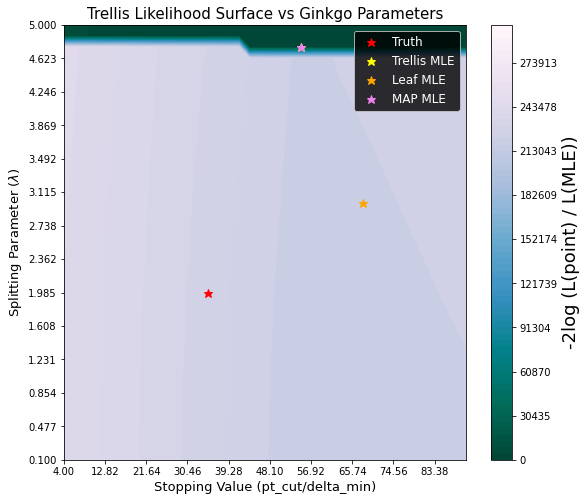

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(likelihood_surface-likelihood_surface[mle_coords])

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-150, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

### Plot results for Trellis MAP Likelihood

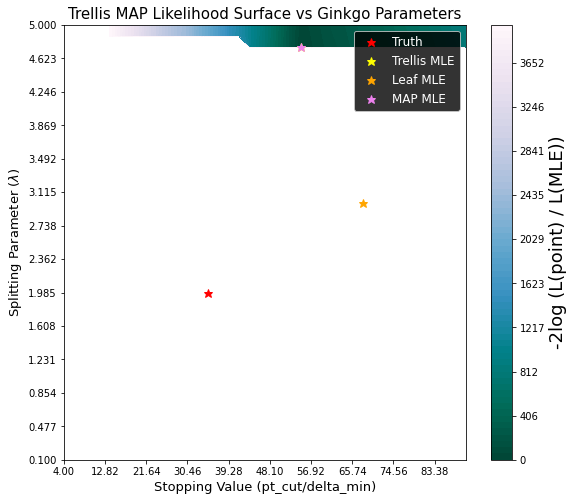

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(likelihood_map_surface-likelihood_map_surface[mle_map_coords])

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-2, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Trellis MAP Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

### Plot results for Leaf-based Likelihoods

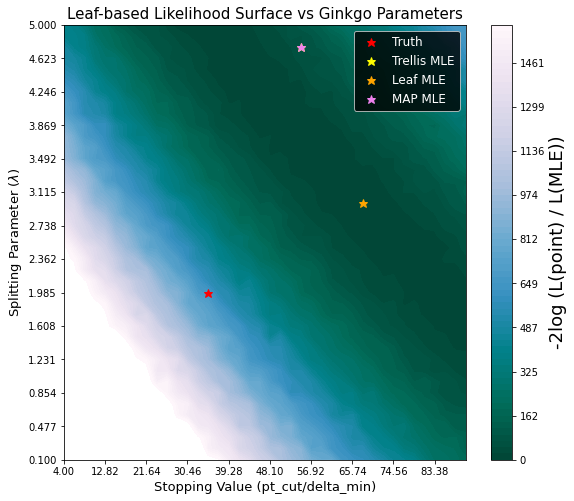

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(leaf_likelihood_surface-leaf_likelihood_surface[mle_leaf_coords])

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-0.8, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Leaf-based Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

### Chi-squared values

In [106]:
-2*(likelihood_surface[truth_bin[1], truth_bin[0]] - likelihood_surface[mle_coords])

417.44331266067456

In [107]:
-2*(likelihood_map_surface[truth_bin[1], truth_bin[0]] - likelihood_map_surface[mle_map_coords])

1139.4433784451103

In [134]:
-2*(leaf_likelihood_surface[truth_bin[1], truth_bin[0]] - leaf_likelihood_surface[mle_leaf_coords])

19.233119783195434

## Look at the distribution of number of leaves at the three points

In [127]:
trellis_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_20000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}".format(
    int(grid_lambda[mle_coords])*1000,
    int(grid_cut[mle_coords]),
    mle_coords[0],
    mle_coords[1]))

In [129]:
leaf_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_20000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}".format(
    int(grid_lambda[mle_leaf_coords])*1000,
    int(grid_cut[mle_leaf_coords]),
    mle_leaf_coords[0],
    mle_leaf_coords[1]))

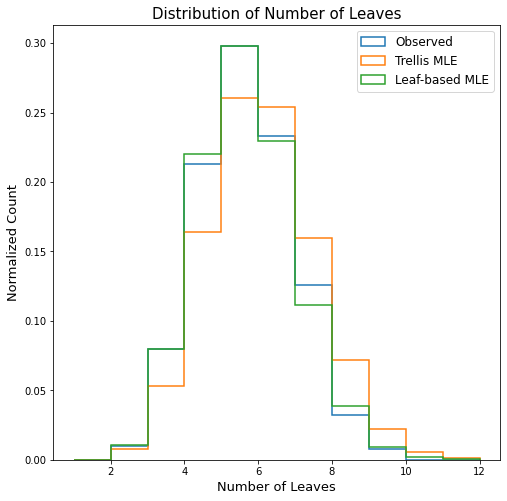

In [130]:
truth_num_leaves = [len(x["leaves"]) for x in gt_trees[:1000]]
trellis_num_leaves = [len(x["leaves"]) for x in trellis_mle_jets]
leaf_num_leaves = [len(x["leaves"]) for x in leaf_mle_jets]

#mle_num_leaves = [len(x["leaves"]) for x in mle_gt_trees]
#print(np.min(mle_num_leaves), np.max(mle_num_leaves))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

ax.hist(truth_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5, density=True, label="Observed")
ax.hist(trellis_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5,  density=True, label="Trellis MLE")
ax.hist(leaf_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5, density=True, label="Leaf-based MLE")

ax.set_xlabel("Number of Leaves", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Number of Leaves", size=15)
ax.legend(fontsize="large")

In [131]:
np.mean(truth_num_leaves), np.mean(trellis_num_leaves)

(5.21, 5.62015)

## Load in the means of the number of leaves at each grid point (outdated grid scan)

In [139]:
mean_leaves = np.load("data/ginkgo_8000_jets_grid_mean_num_leaves.npy")

In [140]:
truth_num_leaves = [len(x["leaves"]) for x in gt_trees[:1000]]
truth_mean_leaves = np.mean(truth_num_leaves)
truth_std_leaves = np.std(truth_num_leaves)

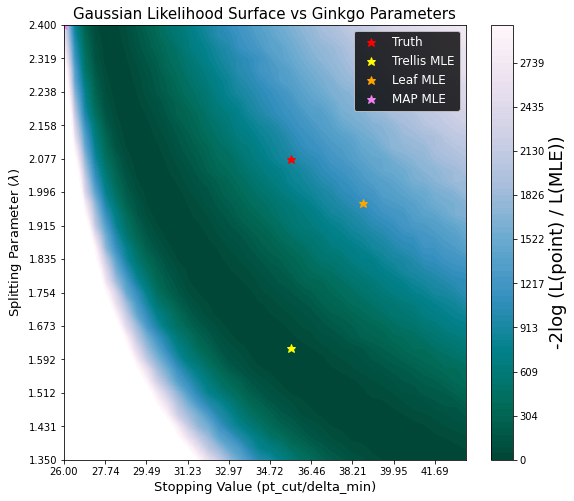

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = 1000*pow(mean_leaves - truth_mean_leaves, 2) / pow(truth_std_leaves, 2)

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-1.5, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Gaussian Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

## TESTING

In [121]:
other_likelihood_surface = likelihood_surface+leaf_likelihood_surface

In [122]:
other_mle_coords = np.unravel_index(np.argmax(other_likelihood_surface[~np.isnan(other_likelihood_surface)], axis=None), other_likelihood_surface.shape)
other_mle_coords

(19, 22)

In [123]:
lambda_vals[other_mle_coords[0]], cut_vals[other_mle_coords[1]]

(1.8615384615384616, 35.58974358974359)

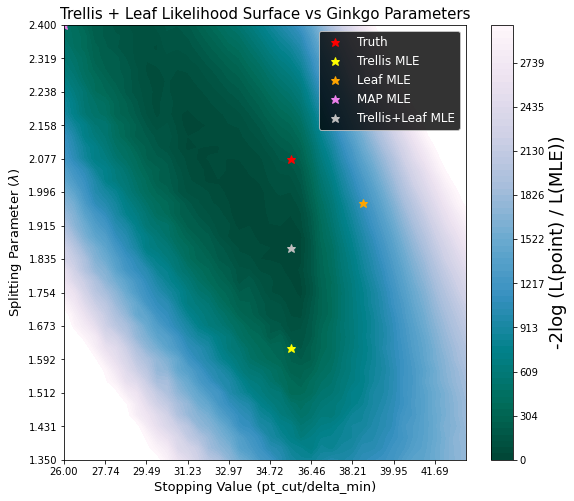

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(other_likelihood_surface-other_likelihood_surface[other_mle_coords])

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-1.5, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")
ax.plot(cut_vals[other_mle_coords[1]], lambda_vals[other_mle_coords[0]], "*", color="silver", markersize=9, label="Trellis+Leaf MLE")


ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Trellis + Leaf Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

In [125]:
-2*(other_likelihood_surface[truth_bin[1], truth_bin[0]] - other_likelihood_surface[other_mle_coords])

196.24254196014954

## Some histograms

In [144]:
n_cuts = 40
n_lambda = 40
N_jets = 5000

cut_min = 26
cut_max = 43
lambda_min = 1.35
lambda_max = 2.4

#cut_vals = np.linspace(4, 90, n_cuts)
#lambda_vals = np.linspace(1e-1, 5, n_lambda)
cut_vals = np.linspace(26, 43, n_cuts)
lambda_vals = np.linspace(1.35, 2.4, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

datadir="/scratch/mdd424/data/trellis"

In [145]:
in_filename = os.path.join(datadir, "trellis_1000_jets_lambda_{:n}_ptcut_{:n}_{}_{}.pkl".format(
    int(grid_lambda[mle_coords])*1000,
    int(grid_cut[mle_coords]),
    mle_coords[0],
    mle_coords[1]))
with open(in_filename, "rb") as fd:
    mle_results = pickle.load(fd, encoding='latin-1')

In [146]:
in_filename = os.path.join(datadir, "trellis_1000_jets_lambda_{:n}_ptcut_{:n}_{}_{}.pkl".format(
    int(grid_lambda[truth_bin[1], truth_bin[0]])*1000,
    int(grid_cut[truth_bin[1], truth_bin[0]]),
    truth_bin[1],
    truth_bin[0]))
with open(in_filename, "rb") as fd:
    truth_results = pickle.load(fd, encoding='latin-1')

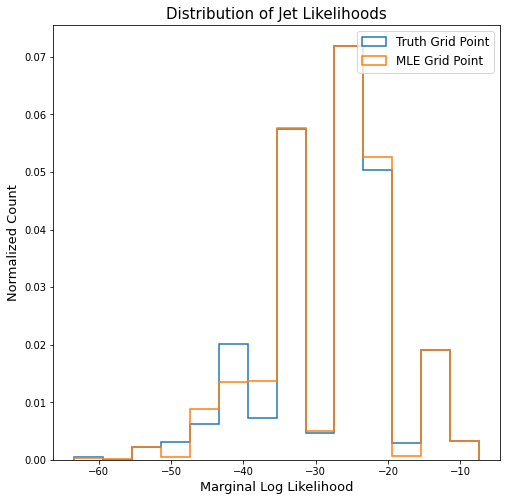

In [156]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

low = np.min([np.min(truth_results["Z"]), np.min(mle_results["Z"])])
high = np.max([np.max(truth_results["Z"]), np.max(mle_results["Z"])])

bins = np.linspace(low, high, 15)

ax.hist(truth_results["Z"], bins=bins, histtype="step", linewidth=1.5, density=True, label="Truth Grid Point")
ax.hist(mle_results["Z"], bins=bins, histtype="step", linewidth=1.5, density=True, label="MLE Grid Point")

ax.set_xlabel("Marginal Log Likelihood", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Jet Likelihoods", size=15)
ax.legend(fontsize="large")

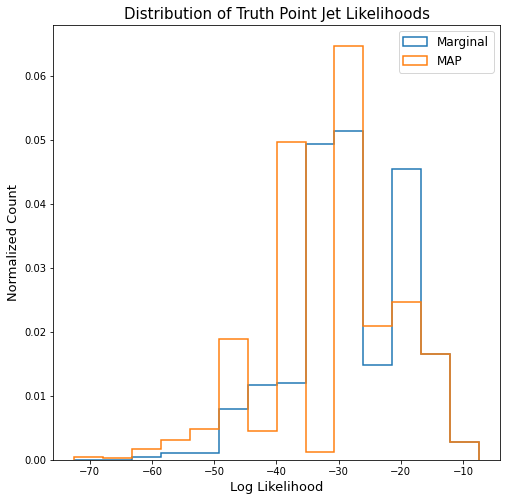

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

low = np.min([np.min(truth_results["Z"]), np.min(truth_results["trellis_MLE"])])
high = np.max([np.max(truth_results["Z"]), np.max(truth_results["trellis_MLE"])])

bins = np.linspace(low, high, 15)

ax.hist(truth_results["Z"], bins=bins, histtype="step", linewidth=1.5, density=True, label="Marginal")
ax.hist(truth_results["trellis_MLE"], bins=bins, histtype="step", linewidth=1.5, density=True, label="MAP")

ax.set_xlabel("Log Likelihood", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Truth Point Jet Likelihoods", size=15)
ax.legend(fontsize="large")

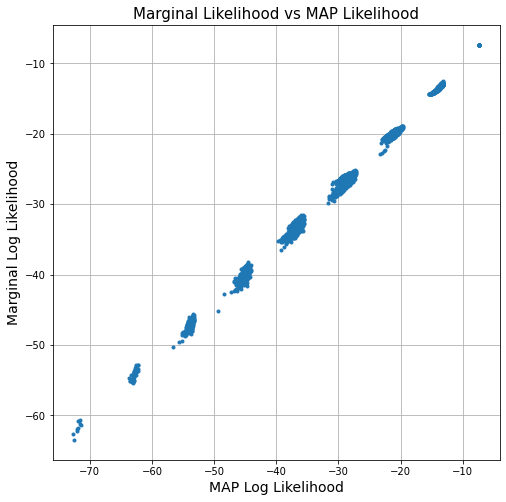

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

ax.plot(truth_results["trellis_MLE"], truth_results["Z"], ".")

ax.set_xlabel("MAP Log Likelihood", size=14)
ax.set_ylabel("Marginal Log Likelihood", size=14)
ax.set_title("Marginal Likelihood vs MAP Likelihood", size=15)
ax.grid()